In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import math
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import model_selection
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from pyentrp import entropy as pyent
import EntropyHub as EH
import neurokit2 as nk
import random
import sampen
import requests
import io
from pprint import pprint
import os
from sklearn import preprocessing
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client.client.flux_table import FluxTable
from datetime import datetime, timedelta
from typing import List
import itertools
from datetime import datetime
from datetime import timedelta
import itertools
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from hurst import compute_Hc, random_walk
import tikzplotlib

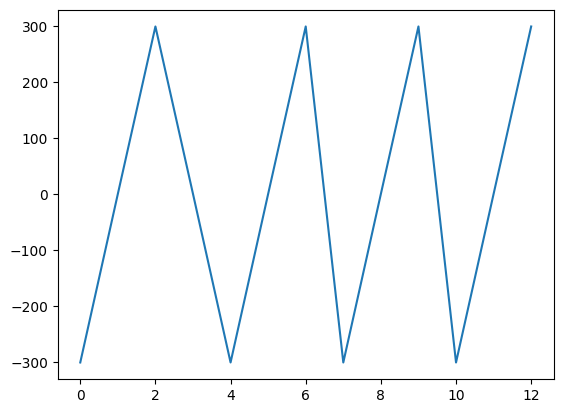

In [2]:
plt.plot([-300,1,300,1,-300,1,300,-300,1,300,-300,1,300])

In [8]:
data_01 = [-300,1,300,1,-300,1,300,-300,1,300,-300,1,300] * 100

In [4]:
acf = sm.tsa.stattools.acf(data_01, nlags=40)
acf

array([ 1.00000000e+00, -2.50001808e-01, -6.24996565e-01,  4.99998422e-01,
        1.24742555e-01, -3.74998570e-01,  1.25256031e-01,  2.49742473e-01,
       -2.49998652e-01, -1.24743837e-01,  2.49999869e-01, -6.57459386e-07,
       -1.24999260e-01])

In [9]:
H, c, data = compute_Hc(data_01, kind='price', simplified=True)

FloatingPointError: invalid value encountered in log10

In [10]:
np.random.seed(42)
random_changes = 1. + np.random.randn(99999) / 1000.
series = np.cumprod(random_changes)  # create a random walk from random changes

# Evaluate Hurst equation
H, c, data = compute_Hc(series, kind='price', simplified=True)

In [11]:
H

0.5183027452775557

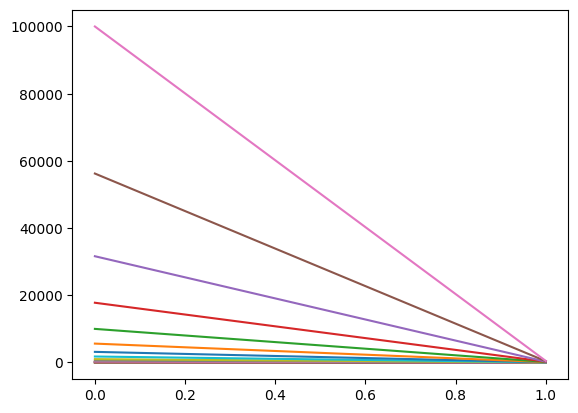

In [12]:
plt.plot(data)

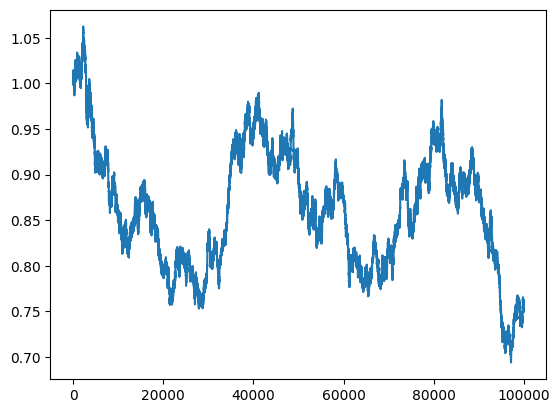

In [21]:
plt.plot(random_walk(99999, min_lookback=1, max_lookback=2, cumprod=True))

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrum(s):
    f = np.fft.rfftfreq(len(s))
    return plt.loglog(f, np.abs(np.fft.rfft(s)))[0]

def noise_psd(N, psd = lambda f: 1):
    X_white = np.fft.rfft(np.random.randn(N));
    S = psd(np.fft.rfftfreq(N))
    # Normalize S
    S = S / np.sqrt(np.mean(S**2))
    X_shaped = X_white * S;
    return np.fft.irfft(X_shaped);

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def white_noise(f):
    return 1;

@PSDGenerator
def blue_noise(f):
    return np.sqrt(f);

@PSDGenerator
def violet_noise(f):
    return f;

@PSDGenerator
def brownian_noise(f):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def pink_noise(f):
    return 1/np.where(f == 0, float('inf'), np.sqrt(f))

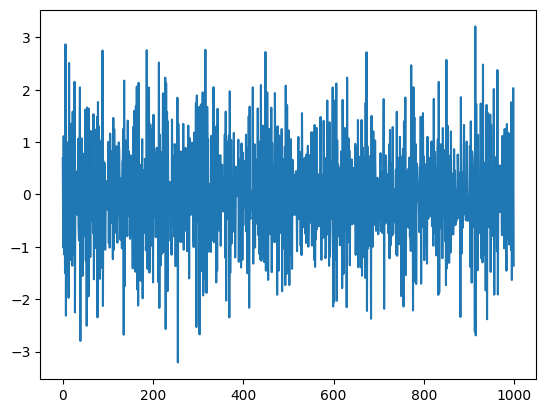

In [5]:
plt.plot(violet_noise(1000))

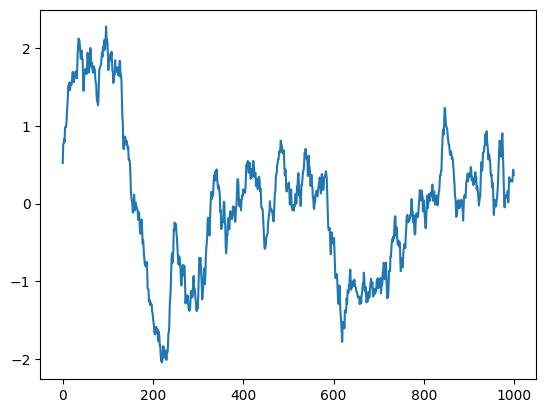

In [6]:
plt.plot(brownian_noise(1000))

In [118]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""

    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

In [2]:
lags = range(2,100)
def hurst_ernie_chan(p):

    variancetau = []; tau = []

    for lag in lags:

        #  Write the different lags into a vector to compute a set of tau or lags
        tau.append(lag)

        # Compute the log returns on all days, then compute the variance on the difference in log returns
        # call this pp or the price difference
        pp = np.subtract(p[lag:], p[:-lag])
        variancetau.append(np.var(pp))

    # we now have a set of tau or lags and a corresponding set of variances.
    #print tau
    #print variancetau

    # plot the log of those variance against the log of tau and get the slope
    m = np.polyfit(np.log10(tau), np.log10(variancetau),1)

    hurst = m[0] / 2

    return hurst

2.256090781770952

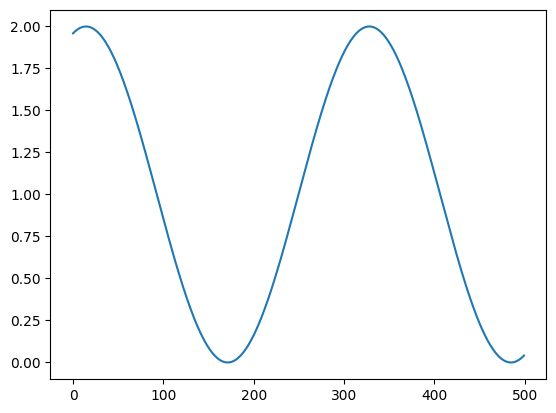

In [15]:
x = np.linspace(-5, 5, 500)

sin_data = (np.sin(x) + 1)
plt.plot(sin_data)
sin_H, _, _ = compute_Hc(sin_data , kind='price')
sin_H

In [187]:
sin_data

array([1.13235175e+01, 1.23084070e+01, 1.32701392e+01, 1.41990662e+01,
       1.50858694e+01, 1.59216526e+01, 1.66980314e+01, 1.74072174e+01,
       1.80420962e+01, 1.85962989e+01, 1.90642660e+01, 1.94413029e+01,
       1.97236272e+01, 1.99084068e+01, 1.99937880e+01, 1.99789143e+01,
       1.98639349e+01, 1.96500032e+01, 1.93392654e+01, 1.89348387e+01,
       1.84407801e+01, 1.78620460e+01, 1.72044420e+01, 1.64745650e+01,
       1.56797370e+01, 1.48279314e+01, 1.39276934e+01, 1.29880538e+01,
       1.20184390e+01, 1.10285757e+01, 1.00283940e+01, 9.02792744e+00,
       8.03721247e+00, 7.06618764e+00, 6.12459401e+00, 5.22187737e+00,
       4.36709354e+00, 3.56881746e+00, 2.83505722e+00, 2.17317370e+00,
       1.58980673e+00, 1.09080850e+00, 6.81184795e-01, 3.65044867e-01,
       1.45560137e-01, 2.49324163e-02, 4.37180854e-03, 8.40845720e-02,
       2.63271050e-01, 5.40133694e-01, 9.11895095e-01, 1.37482584e+00,
       1.92428195e+00, 2.55475142e+00, 3.25990956e+00, 4.03268242e+00,
      

In [217]:
hurst_ernie_chan(sin_data)

0.9823020267427046

In [233]:
x = np.linspace(-5, 5, 500)

sin_data = (np.sin(x) + 1)
y = white_noise(5000) + 5
# y = sin_data

get_hurst_exponent(y), hurst_ernie_chan(y), compute_Hc(y , kind='price')


(0.002386591121861449,
 0.0017094209580410947,
 (0.26359385398694263,
  1.7462016736920623,
  [[10, 17, 31, 56, 100, 177, 316, 562, 1000, 1778, 3162, 5000],
   [2.9432431663530605,
    3.6253660461751736,
    4.44330005893314,
    5.281715596345508,
    6.256838523419446,
    7.051395466245549,
    8.120039649767763,
    9.020893424895279,
    10.037399215531213,
    12.743318105090031,
    15.402655584543506,
    15.591514427566382]]))

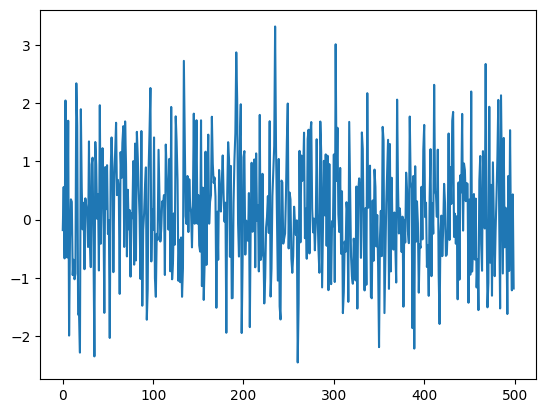

In [224]:
plt.plot(white_noise(500))

In [81]:
pink_data2 = pink_noise(100)
pink_H2, _, _ = compute_Hc(pink_data2 + 10, kind='price', simplified=True)
pink_H2

0.2840825706793933

0.283879810885758

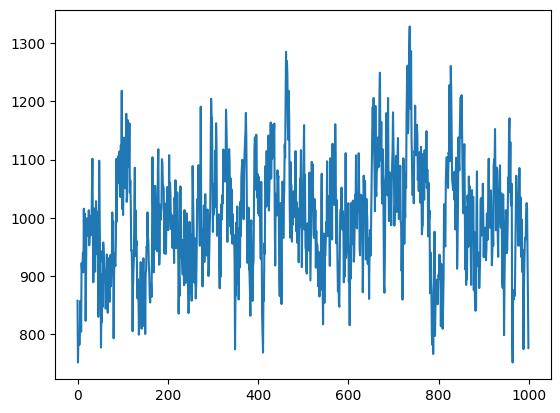

In [39]:
plt.plot((pink_noise(1000)+10) * 100)

In [41]:
pink_data = (pink_noise(100) + 10 * 100)
pink_H, _, _ = compute_Hc(pink_data, kind='price', simplified=True)
pink_H

0.40386123735372487

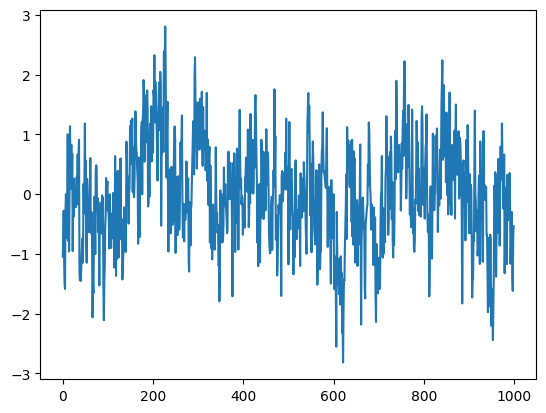

In [246]:
plt.plot(pink_data)

plt.savefig('pink_data.png')

In [44]:
white_data = (white_noise(100) + 10) * 100
white_H, _, _ = compute_Hc(white_data, kind='price', simplified=True)
white_H

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

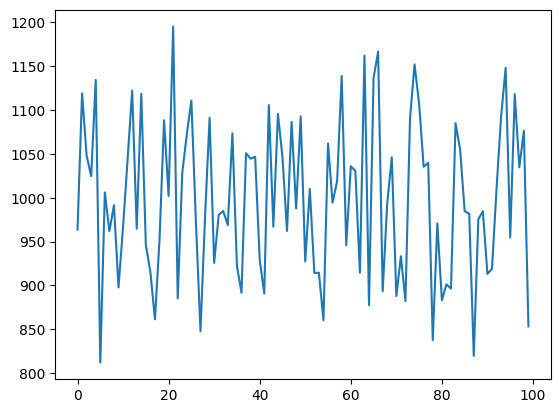

In [43]:
plt.plot(white_data)
plt.savefig('white_data.png')

In [30]:
brownian_data = brownian_noise(100)
brownian_H, _, _ = compute_Hc(brownian_data + 10, kind='price', simplified=True)
brownian_H

0.5449726518154545

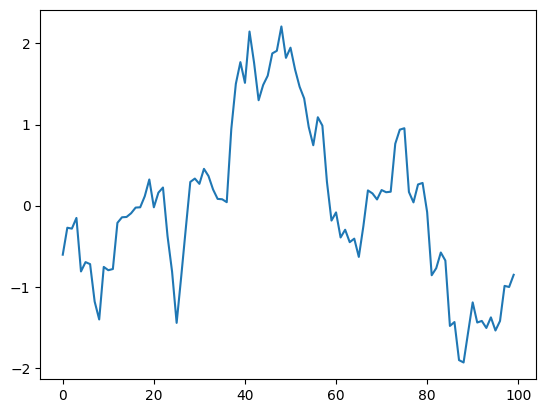

In [31]:
plt.plot(brownian_data)
plt.savefig('brownian_data.png')

In [32]:
white_std = np.std(white_data)
white_std

0.9136184991742123

In [33]:
brownian_std =np.std(brownian_data)
brownian_std

1.0057749138450118

In [34]:
pink_fuzzy = nk.entropy_fuzzy(white_data)
pink_fuzzy

(1.62761866472315,
 {'Dimension': 2, 'Delay': 1, 'Tolerance': 0.1836442280780901})

In [268]:
brownian_fuzzy = nk.entropy_fuzzy(brownian_data)
brownian_fuzzy

(0.31822378864069234,
 {'Dimension': 2, 'Delay': 1, 'Tolerance': 0.1528530675930863})

In [269]:
white_fuzzy = nk.entropy_fuzzy(white_data)
white_fuzzy

(1.6654791091169285,
 {'Dimension': 2, 'Delay': 1, 'Tolerance': 0.19638577494498943})

In [265]:
pink_sample = nk.entropy_sample(pink_data)
pink_sample

(1.91116481350943,
 {'Dimension': 2, 'Delay': 1, 'Tolerance': 0.17247214838393804})

In [266]:
brownian_sample = nk.entropy_sample(brownian_data)
brownian_sample

(0.42425824747043445,
 {'Dimension': 2, 'Delay': 1, 'Tolerance': 0.1528530675930863})

In [205]:
sin_fuzzy = nk.entropy_fuzzy(sin_data)
sin_fuzzy

(0.23633444511547447,
 {'Dimension': 2, 'Delay': 1, 'Tolerance': 1.4179563687460193})

In [264]:
white_fuzzy = nk.entropy_fuzzy(white_data)
white_fuzzy

(1.6654791091169285,
 {'Dimension': 2, 'Delay': 1, 'Tolerance': 0.19638577494498943})